In [1]:
!pip install japanize_matplotlib

In [2]:
import pandas as pd
import numpy as np 
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

import japanize_matplotlib

In [3]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    
    
    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

In [4]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components,1,1+i)
        ax.plot(dates, component_mean, lw=2)
        ax.fill_between(dates,
                         component_mean-2*component_stddev,
                         component_mean+2*component_stddev,
                         color=c2, alpha=0.5)
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

In [5]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
    """Plot a time series against a model's one-step predictions."""

    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    fig=plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,1,1)
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax

In [6]:
data = pd.read_csv('data.csv')
data = data.iloc[::-1]
data = data.reset_index()
data.head()

,index,日付,クリック数,表示回数,CTR,掲載順位
0,485,2020-01-03,34,406,8.37%,21.20
1,484,2020-01-04,28,387,7.24%,20.01
2,483,2020-01-05,63,706,8.92%,14.29
3,482,2020-01-06,97,1024,9.47%,13.00
4,481,2020-01-07,77,901,8.55%,14.99


In [7]:
click = data['クリック数'].values.astype(np.float)
view = data['表示回数'].values.astype(np.float)
rank = data['掲載順位'].values.astype(np.float)

num_forecast_steps = 28
click_training_data = click[:-num_forecast_steps]

dates = np.arange('2020-01-03', '2021-05-03',np.timedelta64(1,'D'), dtype='datetime64')
loc = mdates.MonthLocator()
fmt = mdates.DateFormatter('%a %b %d')

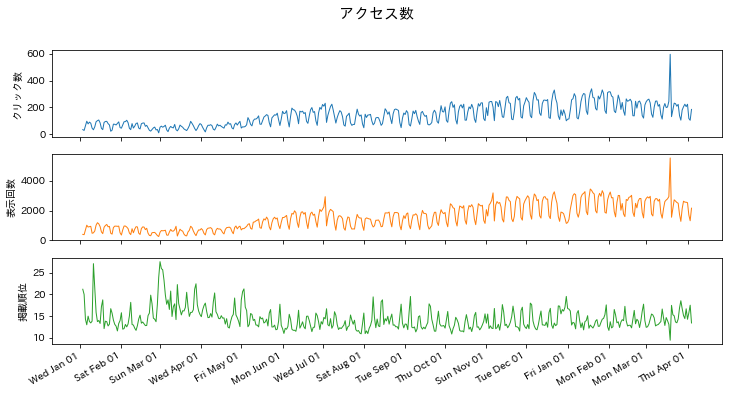

In [8]:
colors = sns.color_palette()
c1, c2, c3 = colors[0], colors[1], colors[2]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(3, 1, 1)

ax.plot(dates[:-num_forecast_steps],
        click[:-num_forecast_steps], lw=1, label="training data")
ax.set_ylabel("クリック数")

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(fmt)

ax = fig.add_subplot(3, 1, 2)

ax.plot(dates[:-num_forecast_steps],
        view[:-num_forecast_steps], lw=1, label="training data", c=c2)
ax.set_ylabel("表示回数")

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(fmt)

ax = fig.add_subplot(3, 1, 3)

ax.plot(dates[:-num_forecast_steps],
        rank[:-num_forecast_steps], lw=1, label="training data", c=c3)
ax.set_ylabel("掲載順位")

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(fmt)
fig.suptitle("アクセス数", fontsize=15)
fig.autofmt_xdate()


In [9]:
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    
    day_of_week_effect = sts.Seasonal(
      num_seasons=7,
      num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')

    view_effect = sts.LinearRegression(
      design_matrix=tf.reshape(view - np.mean(view),
                               (-1, 1)), name='view_effect')
    
    rank_effect = sts.LinearRegression(
      design_matrix=tf.reshape(rank - np.mean(rank),
                               (-1, 1)), name='rank_effect')
    
    autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')

    model = sts.Sum([trend,
                     day_of_week_effect,
                     view_effect,
                     rank_effect,
                     autoregressive],
                    observed_time_series=observed_time_series)
    
    return model

In [10]:
click_model = build_model(click_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=click_model)

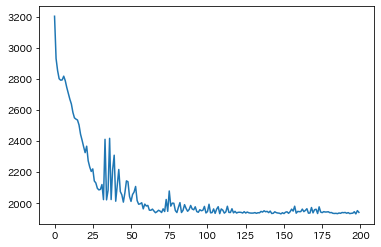

In [11]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=click_model.joint_log_prob(
        observed_time_series=click_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
    return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_demand_ = variational_posteriors.sample(50)

In [12]:
print("Inferred parameters:")
for param in click_model.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.9356200660984874 +- 1.4722306326053798
LocalLinearTrend/_level_scale: 0.4142047715878812 +- 0.319658962676441
LocalLinearTrend/_slope_scale: 0.017344033556036517 +- 0.016982766014228663
day_of_week_effect/_drift_scale: 1.0780415045514022 +- 2.537018633221566
view_effect/_weights: [0.09388161] +- [0.00200592]
rank_effect/_weights: [-1.41992739] +- [0.26260309]
autoregressive/_coefficients: [0.17327665] +- [0.04352073]
autoregressive/_level_scale: 14.199112698013966 +- 0.3366558688670632


In [13]:
demand_forecast_dist = tfp.sts.forecast(
    model=click_model,
    observed_time_series=click_training_data,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=num_forecast_steps)

In [14]:
num_samples=10

(
    demand_forecast_mean,
    demand_forecast_scale,
    demand_forecast_samples
) = (
    demand_forecast_dist.mean().numpy()[..., 0],
    demand_forecast_dist.stddev().numpy()[..., 0],
    demand_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

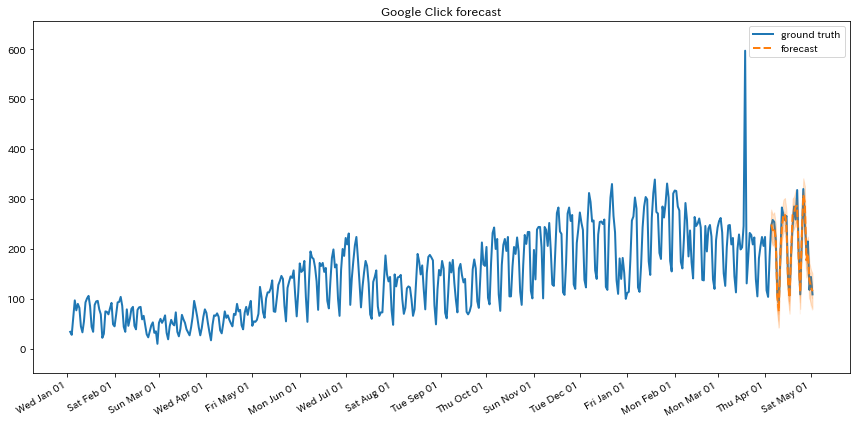

In [15]:
fig, ax = plot_forecast(dates, click,
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title="Google Click forecast",
                        x_locator=loc, 
                        x_formatter=fmt)

fig.tight_layout()

In [16]:

# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    click_model,
    observed_time_series=click_training_data,
    parameter_samples=q_samples_demand_)

forecast_component_dists = sts.decompose_forecast_by_component(
    click_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

In [17]:

demand_component_means_, demand_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    demand_forecast_component_means_,
    demand_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

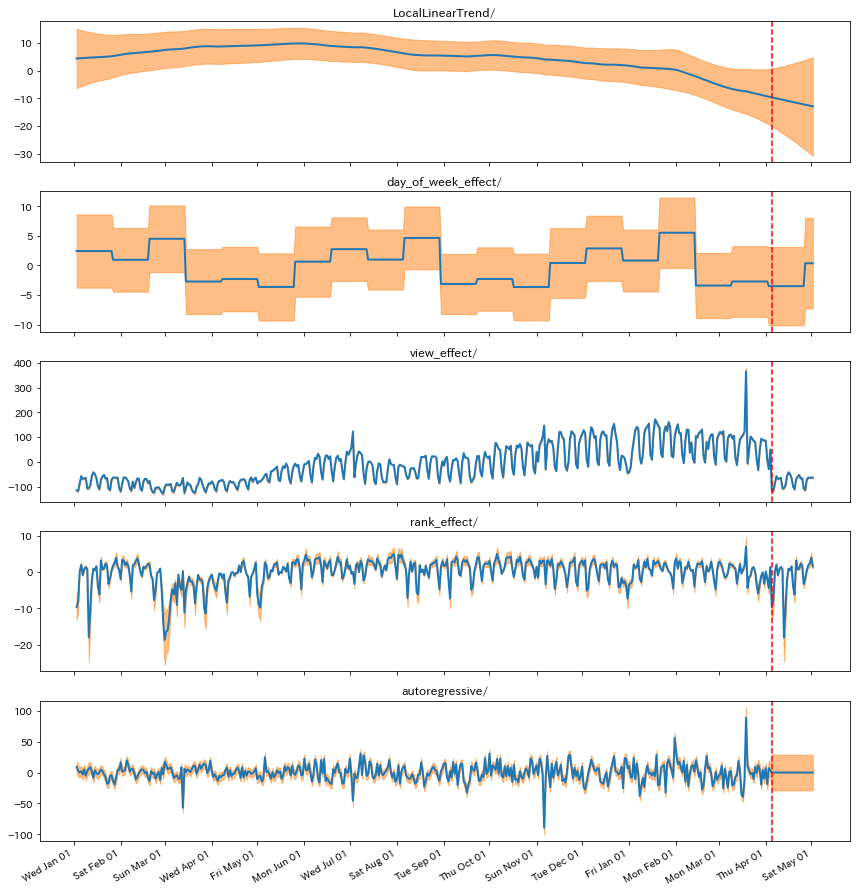

In [18]:

# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=loc, 
    x_formatter=fmt)
for ax in axes.values():
    ax.axvline(dates[-num_forecast_steps], linestyle="--", color='red')

In [19]:
demand_one_step_dist = sts.one_step_predictive(
    click_model,
    observed_time_series=click,
    parameter_samples=q_samples_demand_)

demand_one_step_mean, demand_one_step_scale = (
    demand_one_step_dist.mean().numpy(), demand_one_step_dist.stddev().numpy())

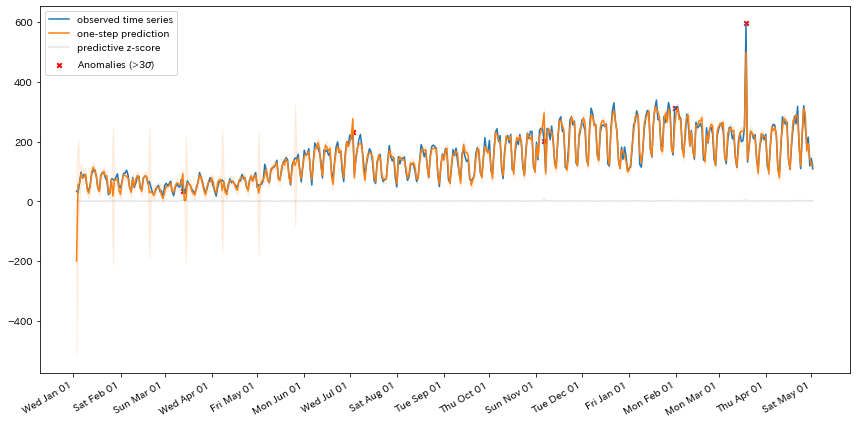

In [20]:
fig, ax = plot_one_step_predictive(
    dates, 
    click,
    demand_one_step_mean, demand_one_step_scale,
    x_locator=loc, x_formatter=fmt)


# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((click - demand_one_step_mean) /
                 demand_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(dates[anomalies],
           click[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(dates, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()